# Konvolucijske neuronske mreže (CNN)

Osnovni pojmovi kod konvolucijskih neuronskih mreža:
 - Konvolucija
 - Sažimanje (pooling)

In [2]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchvision.models import vgg16


import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


### Konvolucija*

Konvolucija u neuronskim mrežama je matematička operacija koja prima dva skupa podataka, ulazni skup (sliku ili značajke) i filter (kernel).

Filter je 2D matrica realnih brojeva. Filter se primjenjuje na gornji lijevi kut ulaznog skupa, pomiče se određeni broj elemenata u desno, to se ponavlja do kraja retka, pa se pomiče prema dolje itd. Filter se primjenjuje na način da se svaki element filtera pomnoži s *preklopljenim* elementom ulaznog skupa te se tako dobiveni brojevi zbroje. Taj novi broj je jedan element izlaznog skupa podataka. Filter se uči za vrijeme treniranja konvolucijske neuronske mreže.

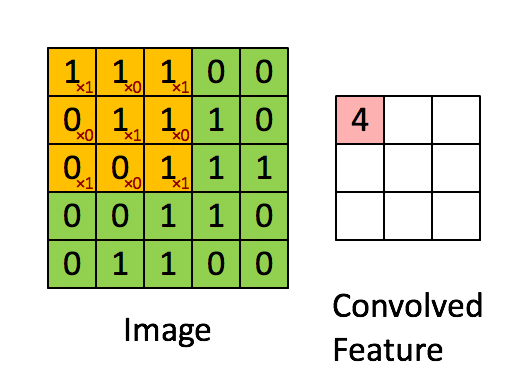






**Ovdje se radi o 2D konvoluciji, ali slični pojmovi i operacije se mogu primijeniti i kod 3D konvolucija*.

Postoje razni parametri konvolucijskih slojeva u neuronskim mrežama. U nastavku su nabrojani neki od njih, a o ostalima možete pročitati [ovdje](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

- broj ulaznih kanala (*in_channels*) - broj kanala ulazne slike/značajki, primjerice 3 za slučaj RGB slike
- broj izlaznih kanala (*out_channels*)
- veličina kernela/filtera (*kernel_size*) - dimenzije kernela
- *stride* - broj piksela koliko se kernel pomiče pri konvoluciji
- *padding* - broj piksela koji se dodaju na rub ulaznih podataka

Probajmo primijeniti konvoluciju na nekakvu sliku.

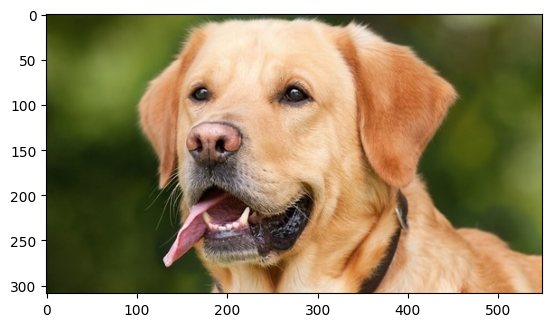

In [4]:
link = "https://www.hindustantimes.com/ht-img/img/2023/08/25/550x309/international_dog_day_1692974397743_1692974414085.jpg"
input_image = imread(link)
plt.imshow(input_image)
plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(input_image)

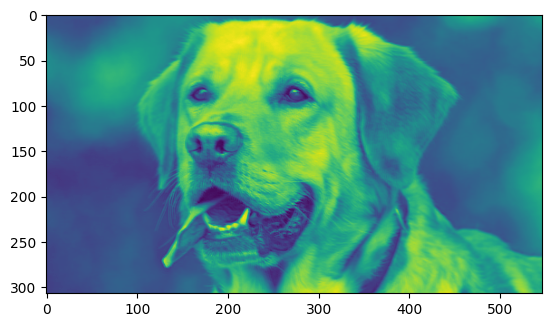

In [6]:
convolution = nn.Conv2d(3, 1, 3)
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Gore je prikazan izlaz iz konvolucije nasumičnih filtera, možemo ispisati te filtere. Također možemo i napraviti svoje filtere te ih primijeniti na ulaznu sliku.

In [7]:
convolution.weight

Parameter containing:
tensor([[[[ 0.0368,  0.0675, -0.0735],
          [ 0.1155, -0.0318, -0.1678],
          [-0.0661, -0.1105,  0.0038]],

         [[ 0.1371, -0.0622,  0.1460],
          [ 0.1376,  0.1574,  0.1826],
          [ 0.1075,  0.0267,  0.1589]],

         [[-0.0227, -0.1908,  0.0755],
          [ 0.0202,  0.1789,  0.1656],
          [-0.0999,  0.0207, -0.0600]]]], requires_grad=True)

In [8]:
our_kernel = [[[[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]]]]
our_kernel = nn.Parameter(torch.Tensor(our_kernel))
convolution.weight = our_kernel

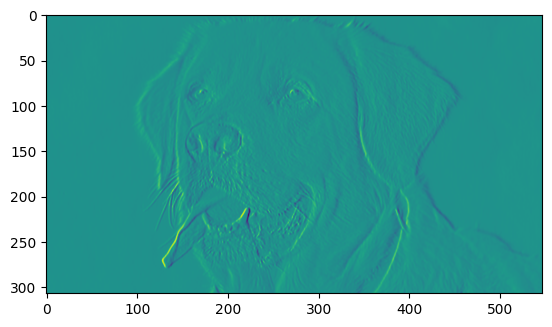

In [9]:
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Možemo primijetiti da smo pomoću gore definiranog filtera detektirali vertikalne rubove na ulaznoj slici.

### Sažimanje

Sloj sažimanja (*pooling layer*) sažima ulazne podatke te im tako smanjuje dimenzije. Primjenjuje se u konvolucijskim neuronskim mrežama nakon jednog ili više konvolucijskih slojeva. Postoje [razni](https://pytorch.org/docs/stable/nn.html#pooling-layers) načini sažimanja, ali najčešći je [*max pooling*](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

*Max pooling* jednostavno uzima određeni segment ulazne matrice i bira najveću vrijednost koja se upisuje u izlaznu matricu. *Max pooling* sloj ima nekoliko parametara, a neki od njih su:
 - `kernel_size` - veličina prozora (kernela), može biti jedan broj ili *tuple*
 - `stride` - broj piksela koliko se prozor pomiče, može biti jedan broj ili *tuple*, zadano je da je jednako veličini prozora

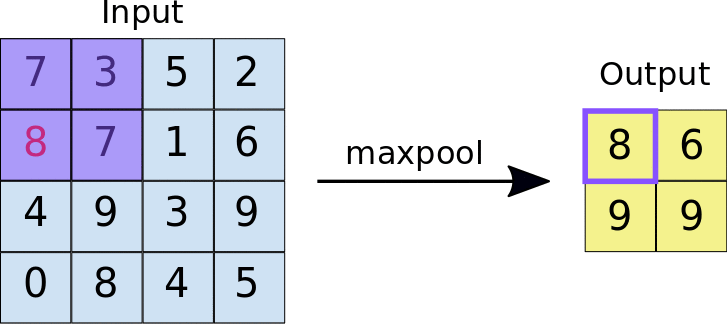

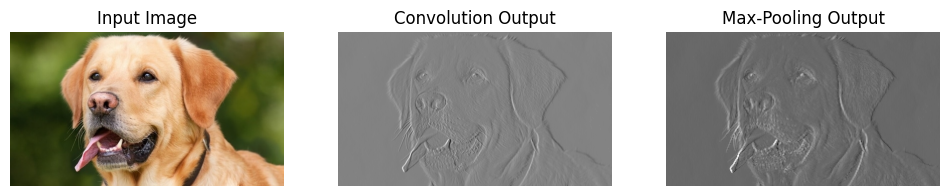

Input shape: torch.Size([3, 309, 549])
Convolution output shape: torch.Size([1, 307, 547])
Max-Pooling output shape: torch.Size([1, 153, 273])


In [10]:
## TODO
## Implement the max pooling layer and use it on the above image of edges
## Check the input and output shapes and how they differ depending on the
## max pooling kernel size
# Define the MaxPooling layer
max_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply the MaxPooling layer to the output of the convolution layer
out_pooled = max_pooling(out)

# Display the input, convolution output, and max-pooled output
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Display the input image
axes[0].imshow(input_image)
axes[0].set_title('Input Image')
axes[0].axis('off')

# Display the output of the convolution layer
axes[1].imshow(out_image, cmap='gray')
axes[1].set_title('Convolution Output')
axes[1].axis('off')

# Display the output of the max-pooling layer
out_pooled_image = out_pooled.detach().numpy().transpose(1, 2, 0)
axes[2].imshow(out_pooled_image, cmap='gray')
axes[2].set_title('Max-Pooling Output')
axes[2].axis('off')

plt.show()

# Display input and output shapes
print("Input shape:", input_tensor.shape)
print("Convolution output shape:", out.shape)
print("Max-Pooling output shape:", out_pooled.shape)


### Konvolucijska neuronska mreža

Standardna konvolucijska mreža je kombinacija 3 vrste slojeva:
 - Konvolucijski slojevi
 - Slojevi sažimanja
 - Potpuno povezani slojevi

Naravno, primjenjuju se razne aktivacijske funkcije nakon konvolucijskih i potpuno povezanih slojeva. Također se koriste i drugi slojevi, koje ćemo odraditi u budućim LV-ovima, povratne veze itd.

CNN-ovi su često izgrađeni na način da se nizaju konvolucijski slojevi popraćeni slojem sažimanja, zatim se opet nizaju konvolucijski slojevi popraćeni slojem sažimanja, što se ponavlja određeni broj puta te se na kraju izlaz iz posljednjeg sloja sažimanja provlači kroz potpuno povezane slojeve. Primjer ovakve jedne mreže (VGG-16) je prikazan na slici. Na ovom primjeru je jasno vidljivo kako se prve dvije dimenzije podataka smanjuju prolaskom kroz mrežu, a treća dimenzija, broj kanala, se povećava. Također je važno naglasiti da je, prije dodavanja potpuno povezanih slojeva, potrebno dodati [sloj za izravnavanje (*flatten*)](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

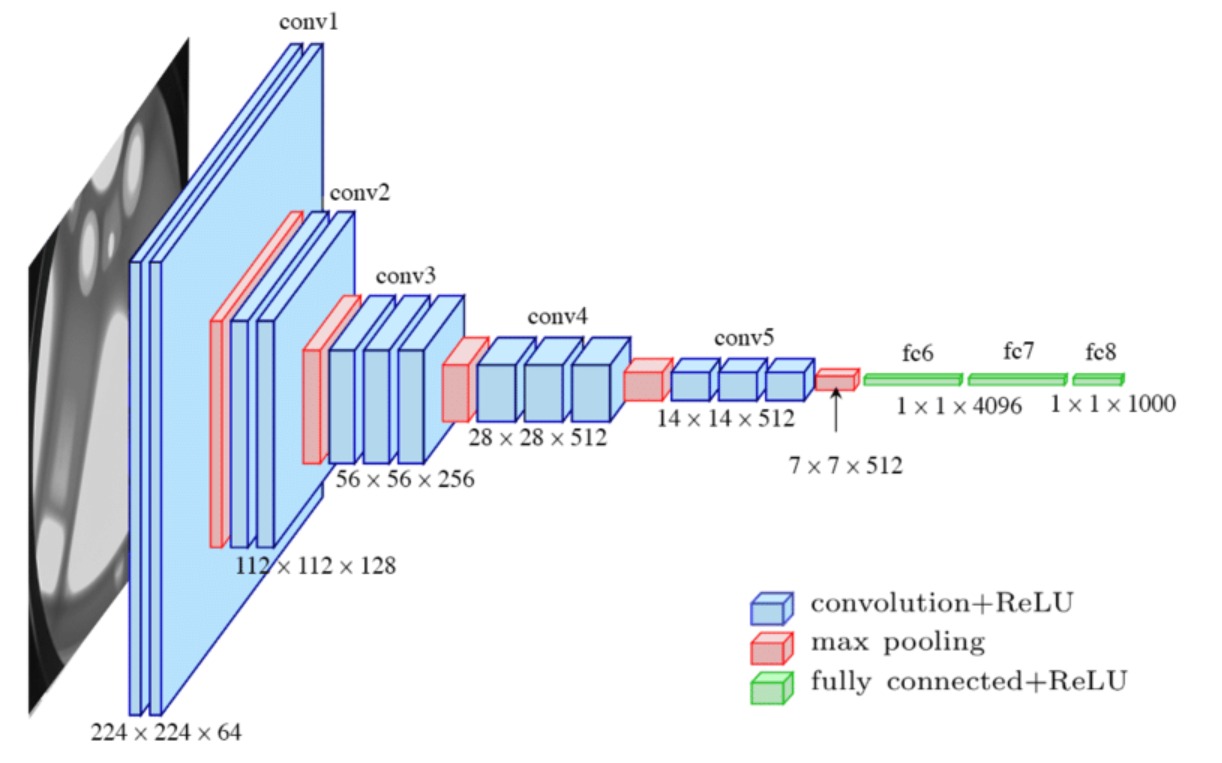

## Zadatak

Potrebno je izraditi i istrenirati konvolucijsku neuronsku mrežu na CIFAR-10 podatkovnom skupu.

CIFAR-10 je podatkovni skup koji se sastoji od 60000 slika u boji veličine 32x32. Svaka od ovih slika je klasificirana u jednu od 10 klasa. Podatkovni skup je podijeljen na skup za treniranje (50000 slika) i skup za testiranje (10000). Potrebno je skup za treniranje dodatno podijeliti na skup za treniranje (40000) i skup za validaciju (10000). Ovo možete učiniti pomoću sljedeće naredbe:

`trainset, valset = torch.utils.data.random_split(whole_trainset, [50000, 10000])`

Taj [podatkovni skup](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) se može vrlo lagano dohvatiti pomoću *torchvision* biblioteke.

In [11]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
## TODO
## divide the trainset into trainset and valset
## containing 40000 and 10000 images respectively
trainset, valset = torch.utils.data.random_split(whole_trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12268289.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


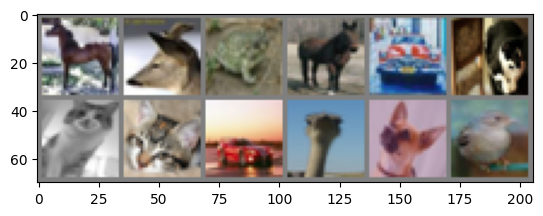

horse deer  frog  horse car   cat   cat   cat   car   bird  dog   bird 


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:12]
labels = labels[:12]

# show images
imshow(torchvision.utils.make_grid(images, nrow=6))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(12)))

#### Mreža

Implementirajte neuronsku mrežu koja se sastoji od tri konvolucijska sloja, svaki od kojih je popraćen ReLU aktivacijskom funckijom i *max pooling* slojem. Za *max pooling* koristite kernel veličine 2x2. Brojeve filtera u konvolucijskim slojevima odaberite proizvoljno (nemojte odabrati prevelike brojeve za ovaj zadatak).

Svi konvolucijski slojevi koriste sljedeće parametre:
 - Veličina filtera (kernela): 3x3
 - *stride*: 1
 - *padding*: 'same'

Nakon konvolucijskih slojeva, dodajte tri potpuno povezana sloja s proizvoljnim brojem neurona. Napomena: Posljednji sloj treba imati 10 izlaza za 10 klasa i ne treba imati aktivacijsku funkciju.

Mreža će se koristiti za rad na podatkovnom skupu koji sadrži slike veličine 32x32, stoga prilagodite potpuno povezane slojeve tim dimenzijama.



In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjust input size based on your data size
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()

        self.fc3 = nn.Linear(256, 10)  # Output layer with 10 classes, no activation

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)

        return x

# Create an instance of the CNN model
cnn_model = CNN()

Nakon što ste definirali mrežu i podatkovne skupove za treniranje i testiranje, vrijeme je za treniranje mreže. Primijenite znanja stečena u prvoj laboratorijskoj vježbi kako biste istrenirali VGG-16 neuronsku mrežu na CIFAR-10 podatkovnom skupu. Za funkciju gubitka koristite [gubitak unakrsne entropije (*cross-entropy loss*)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [14]:
## TODO
## Define the loss function and the optimizer
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16

# Define the transformation for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the VGG-16 model
vgg16_model = vgg16(pretrained=False, num_classes=10)  # 10 output classes for CIFAR-10
vgg16_model.to(device)  # Move the model to GPU if available

# Define the loss function (CrossEntropyLoss) and the optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Za razliku od prve vježbe, ovdje je potrebno dodati i kontinuirano praćenje vrijednosti funkcije gubitka na skupovima za treniranje i validaciju po epohama. Kako biste ovo postigli, možete kumulativno zbrajati vrijednost funkcije gubitka u svakoj iteraciji treniranja.

Prilikom treninga, na kraju svake epohe izračunajte točnost modela na skupovima za treniranje i validaciju. Hint: Koristite istu funkciju za izračun vrijednosti funkcije gubitka (loss) i za točnost na validacijskom skupu.

Ove vrijednosti možete odmah ispisivati na ekran, ali je bitno da ih spremite u varijable kojima ćete moći poslije pristupiti zbog vizualizacije i analize (možete te varijable vratiti kao izlaze iz funkcije za treniranje).

Koristite tqdm za praćenje tijeka treniranja za svaku epohu posebno (za razliku od praćenja tijeka treniranja za sve epohe zajedno). To možete učiniti na sljedeći način:

`for data_inputs, data_labels in tqdm(data_loader, 'Epoch %d'%(epoch + 1)):`,

gdje je `epoch` broj epohe za koju se ispisuje tijek.


In [15]:
from tqdm.notebook import tqdm

def eval_model(model, data_loader, loss_module):
    model.eval()  # Set model to eval mode
    true_preds, num_preds, total_loss = 0., 0., 0.

    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)

            # Calculate loss
            loss = loss_module(preds, data_labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, pred_labels = torch.max(preds.data, dim=1)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    avg_loss = total_loss / len(data_loader)
    return acc, avg_loss


In [27]:
def train_model(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        # Iterate over the training dataset
        for data_inputs, data_labels in tqdm(train_data_loader, desc=f'Epoch {epoch + 1}'):
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            preds = model(data_inputs)
            loss = loss_module(preds, data_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(preds.data, 1)
            total_train_preds += data_labels.size(0)
            correct_train_preds += (predicted == data_labels).sum().item()

        # Calculate training accuracy and loss
        train_accuracy = correct_train_preds / total_train_preds
        train_losses.append(total_train_loss / len(train_data_loader))
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        val_accuracy, val_loss = eval_model(model, val_data_loader, loss_module)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {100.0 * train_accuracy:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {100.0 * val_accuracy:.2f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Assuming you have already defined model, optimizer, trainloader, valloader, and criterion
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

# After loading the model, move it to the appropriate device
cnn_model.to(device)


train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    cnn_model, optimizer, trainloader, valloader, criterion, num_epochs=10
)

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 2.3032, Train Acc: 10.00%, Val Loss: 2.3036, Val Acc: 9.57


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16

# Check if GPU is available and set device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transformation for the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation: random horizontal flip
    transforms.RandomRotation(10),        # Data augmentation: random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset with data augmentation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Load the test set without data augmentation
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the VGG-16 model
vgg16_model = vgg16(pretrained=False, num_classes=10)  # 10 output classes for CIFAR-10
vgg16_model.to(device)

# Define the loss function (CrossEntropyLoss) and the optimizer (SGD) with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10  # You can adjust this value based on your needs
for epoch in range(num_epochs):
    vgg16_model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0

    for data_inputs, data_labels in trainloader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16_model(data_inputs)
        loss = criterion(outputs, data_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train_preds += data_labels.size(0)
        correct_train_preds += (predicted == data_labels).sum().item()

    train_accuracy = correct_train_preds / total_train_preds
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(trainloader):.4f}, Train Acc: {100 * train_accuracy:.2f}%')

print('Finished Training')

# Evaluate the model on the test set
vgg16_model.eval()
correct_test_preds = 0
total_test_preds = 0

with torch.no_grad():
    for data_inputs, data_labels in testloader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        outputs = vgg16_model(data_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test_preds += data_labels.size(0)
        correct_test_preds += (predicted == data_labels).sum().item()

test_accuracy = correct_test_preds / total_test_preds
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 2.2445, Train Acc: 13.37%
Epoch 2/10, Train Loss: 1.8928, Train Acc: 27.59%
Epoch 3/10, Train Loss: 1.5839, Train Acc: 40.51%
Epoch 4/10, Train Loss: 1.3766, Train Acc: 49.12%
Epoch 5/10, Train Loss: 1.2197, Train Acc: 55.46%
Epoch 6/10, Train Loss: 1.1201, Train Acc: 59.24%
Epoch 7/10, Train Loss: 1.0249, Train Acc: 63.05%
Epoch 8/10, Train Loss: 0.9399, Train Acc: 66.08%
Epoch 9/10, Train Loss: 0.8707, Train Acc: 69.11%
Epoch 10/10, Train Loss: 0.8174, Train Acc: 71.14%
Finished Training
Test Accuracy: 68.48%


In [30]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

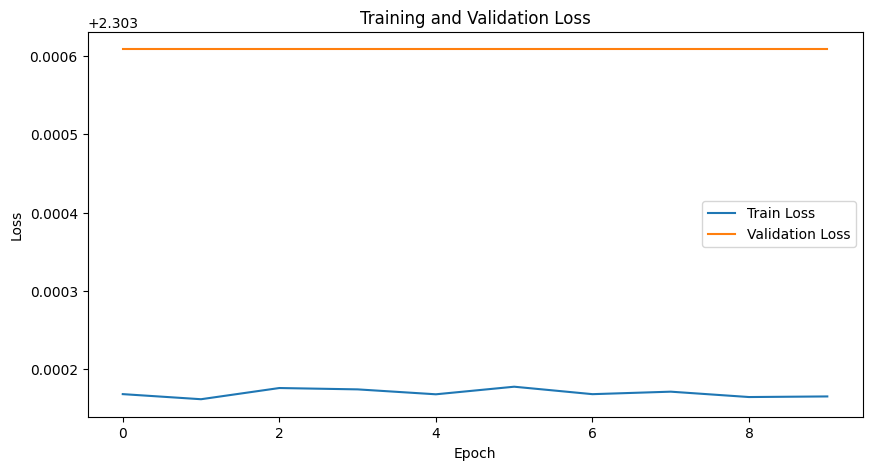

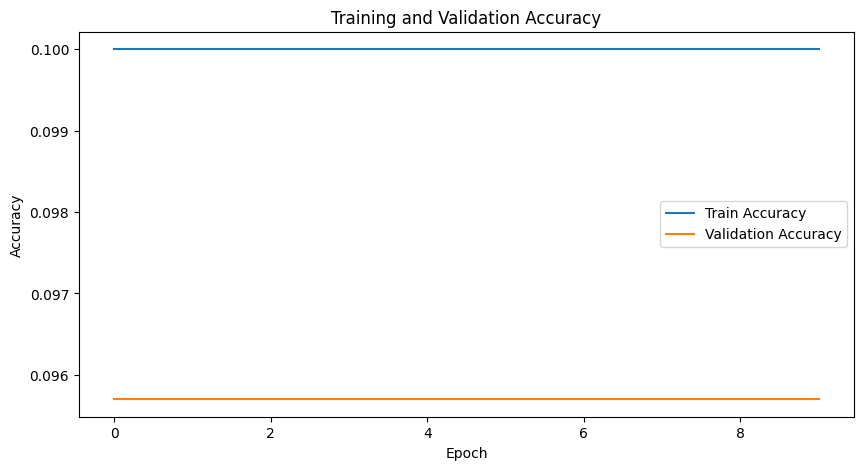

In [31]:
## TODO
## Visualize the loss and accuracy throughout the training process
import matplotlib.pyplot as plt

# Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Istestirajte istreniranu neuronsku mrežu na skupu za testiranje, ispišite ukupnu točnost i vizualizirajte neke od predikcija.

In [ ]:
## TODO
## Test the network
def test_model(model, test_data_loader, loss_module):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    correct_test_preds = 0
    total_test_preds = 0

    with torch.no_grad():  # Disable gradient calculation during testing
        for data_inputs, data_labels in tqdm(test_data_loader, desc='Testing'):
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            preds = model(data_inputs)
            loss = loss_module(preds, data_labels)

            total_test_loss += loss.item()

            _, predicted = torch.max(preds.data, 1)
            total_test_preds += data_labels.size(0)
            correct_test_preds += (predicted == data_labels).sum().item()

    # Calculate test accuracy and loss
    test_accuracy = correct_test_preds / total_test_preds
    test_loss = total_test_loss / len(test_data_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {100.0 * test_accuracy:.2f}%")

# Assuming you have already defined model, testloader, and criterion
test_model(model, testloader, criterion)


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 2.3023, Test Accuracy: 10.15%
